# **Toxic Comment Classification Challenge**

### **1. Descripcion del problema**

 Em várias plataformas de mídia social, as seçães de comentários permitem que os usuários
 compartilhem ideias e discutam diferentes pontos de vista. No entanto, há um abuso
 de linguagem tóxica, especialmente no X (antigo Twitter), que não tem regras rígidas
 para regular esse tipo de comentário, o que está afetando a qualidade dessas conversas.
 Comentários que incluem ameaças, insultos, linguagem vulgar ou ódio contra certos gru
 pos sociais, dificultando um diálogo saudável.

### **2. Análise descritiva de cada atributo**

### **Importação de biblioteca e carregamento de dados**

In [2]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from textstat import flesch_reading_ease
import warnings
warnings.filterwarnings("ignore")

# Adicional para BERTopic
from bertopic import BERTopic
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Carregando os dados
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Adicionar a coluna length (número de caracteres no comentário)
train['length'] = train['comment_text'].apply(lambda x: len(str(x)))

# Adicionar a coluna flesch_scaler (índice de legibilidade)
train['flesch_scaler'] = train['comment_text'].apply(lambda x: flesch_reading_ease(str(x)))
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,flesch_scaler
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,66.370388
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,73.795735
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,65.725000
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,51.112030
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,89.606731


#### **a) Identificar os tipos de atributos**

A identificação dos tipos de atributos consiste em classificar cada coluna do dataset conforme sua natureza: **nominal**, **ordinal**, **binário**, **contínuo** ou **discreto**.

<center>

| Coluna | Tipo de Atributo | Descrição |
|-----------|-----------|---------------|
| id | Categórico nominai | Identificador único. <br>Não tem ordem nem significado além de identificar a fila |
| comment_text | Categórico nominai | Texto livre que contém o comentário a classificar.<br>Não team hierarquia nem ordem |
| toxic <br> severe_toxic <br> obscene <br> threat <br> insult<br> identity_hate| Binário assimétrico | 1 = Tóxico, 0 = Não Tóxico. <br> A classe positiva (1) é menos frequente, pelo que é assimétrica |
| length         | Contínuo             | Número total de caracteres no comentário.                                |
| flesch_scaler  | Contínuo             | Índice de legibilidade Flesch Reading Ease. Valores mais altos indicam maior facilidade de leitura. |


</center>

- **`id`** e **`comment_text`** são **atributos nominais**, não usados diretamente na modelagem.
- As etiquetas (**`toxic`**, **`severe_toxic`**, **`obscene`**, **`threat`**, **`insult`**, **`identity_hate`**.) são **binárias assimétricas**, importantes para prever comportamentos tóxicos.

Além das variáveis fornecidas no dataset original, foram adicionados dois novos atributos numéricos:

- **`length`**: representa o número de caracteres no comentário. Pode indicar complexidade, extensão ou ênfase do texto.
- **`flesch_scaler`**: mede a legibilidade do comentário com base no índice Flesch Reading Ease. Comentários mais simples tendem a ter pontuações mais altas.

#### **b) Para atributo numérico: análise descritiva e visualização**

Nesta etapa, devemos identificar para cada atributo numérico e não categorizado:

- Intervalo de valores (mínimo e máximo).

- Valor médio.

- Desvio-padrão.

- Possíveis valores aberrantes (outliers).


              length  flesch_scaler
count  159571.000000  159571.000000
mean      394.073221      60.118723
std       590.720282     128.131875
min         6.000000  -36681.810000
25%        96.000000      49.484853
50%       205.000000      63.176029
75%       435.000000      76.553333
max      5000.000000     134.080000


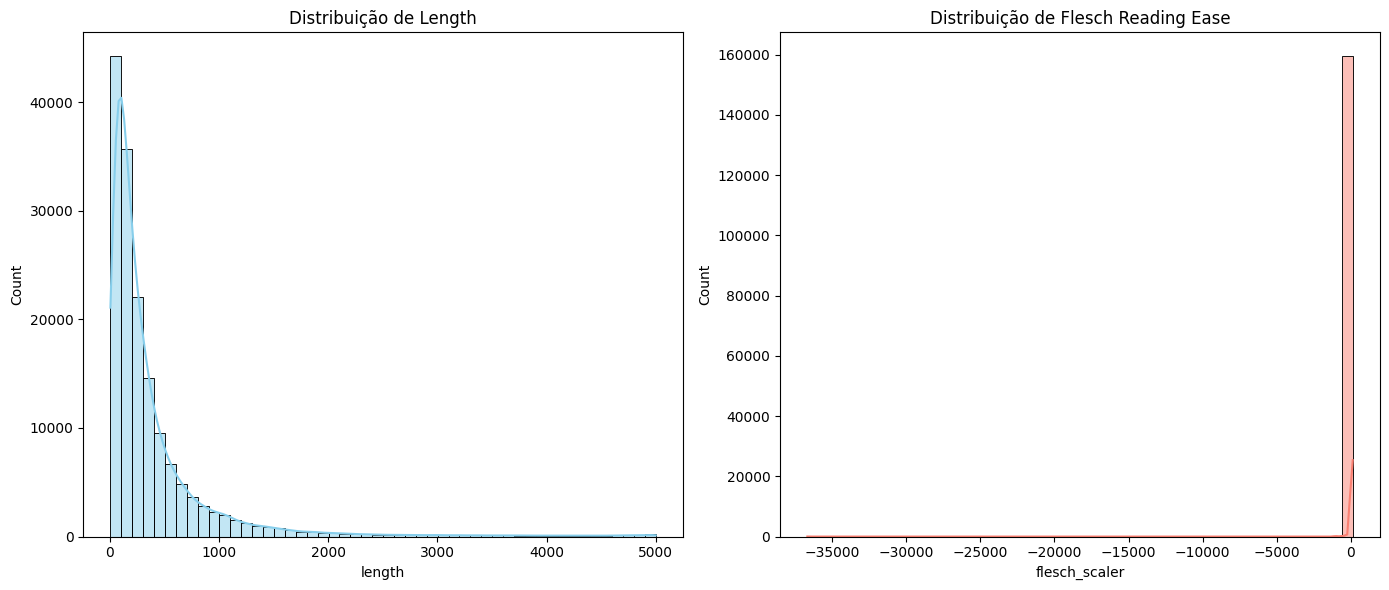

In [6]:
# Estatísticas descritivas
print(train[['length', 'flesch_scaler']].describe())

# Histograma
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train['length'], bins=50, kde=True, color='skyblue')
plt.title('Distribuição de Length')

plt.subplot(1, 2, 2)
sns.histplot(train['flesch_scaler'], bins=50, kde=True, color='salmon')
plt.title('Distribuição de Flesch Reading Ease')

plt.tight_layout()
plt.show()

**Lenght**
- A maioria dos comentários possui um comprimento curto (menor que 500 caracteres).
- A distribuição é assimétrica à direita (distribuição enviesada positivamente), com poucos comentários extremamente longos (outliers).
- Esse padrão é típico em dados de texto, pois a maioria dos comentários tende a ser breve.

**Flesch Reading Ease**
- A maioria dos valores está concentrada em torno de 0, com valores negativos extremos que indicam baixa legibilidade.
- Valores tão negativos sugerem possíveis erros na extração dos textos (ex: strings vazias ou mal formatadas).

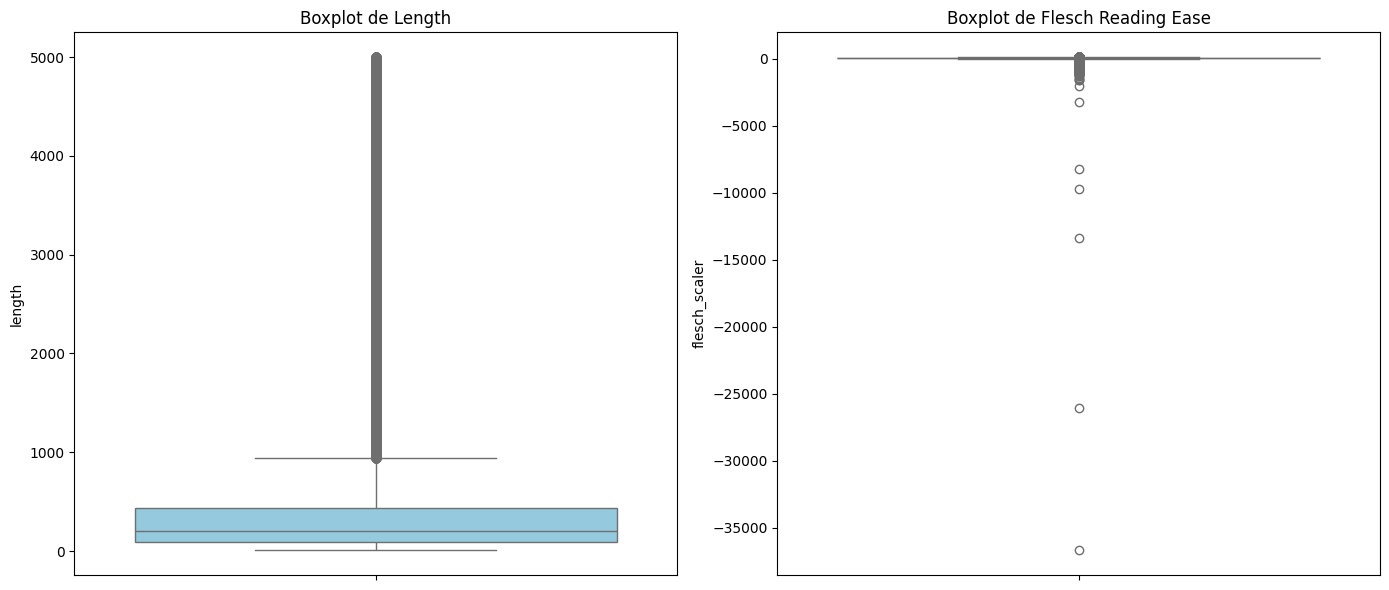

In [7]:
# Boxplots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=train['length'], color='skyblue')
plt.title('Boxplot de Length')

plt.subplot(1, 2, 2)
sns.boxplot(y=train['flesch_scaler'], color='salmon')
plt.title('Boxplot de Flesch Reading Ease')

plt.tight_layout()
plt.show()

**Lenght**
- A mediana é visivelmente baixa, confirmando que a maioria dos comentários é curta.
- Existem vários **outliers** com comprimento significativamente maior que o terceiro quartil, sugerindo a necessidade de tratamento dependendo do modelo usado.

**Flesch Reading Ease**
- Há uma grande quantidade de outliers muito abaixo de 0, reforçando a suspeita de dados problemáticos.
- A dispersão é alta, o que indica que os comentários possuem uma variabilidade significativa em termos de facilidade de leitura.

### ***c) Distribuição de valores e popularidade dos atributos***

Nesta etapa, para cada atributo **binário, nominal ou ordinal**, devemos:

- Identificar os **valores possíveis**.  
- Verificar a **popularidade** ou **frequência relativa** de cada valor (distribuição de probabilidade).

No nosso dataset, analisamos as **etiquetas binárias**: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult` e `identity_hate`.  
Para o atributo `comment_text` (nominal), não é viável analisar distribuição direta, mas podemos analisar o **comprimento** ou outras métricas.


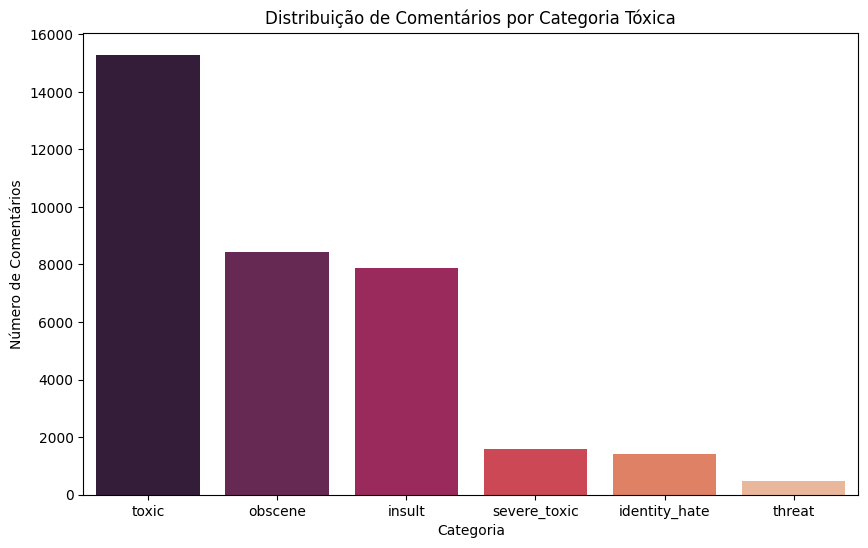

In [9]:
# Lista de columnas de etiquetas
bin_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Conteo absoluto por etiqueta
label_counts = train[bin_cols].sum().sort_values(ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="rocket")
plt.title('Distribuição de Comentários por Categoria Tóxica')
plt.ylabel('Número de Comentários')
plt.xlabel('Categoria')
plt.show()


Classe **"toxic"**:

- É de longe a mais frequente (~15.000 ocorrências).

- Isso sugere que se trata de um rótulo genérico que agrupa várias formas de toxicidade.

Classe **"Obscene"** e **"insult"**:

- São as segundas mais comuns (~8.000 e ~7.000 ocorrências, respectivamente).

- Indicam que insultos e linguagem obscena são frequentes no conjunto.

Classe **"severe_toxic"**, **"identity_hate"** e **"threat"**:

- São claramente sub-representadas, especialmente "threat" e "identity_hate", que apresentam pouquíssimas ocorrências (~1.000 ou menos).

- Isso introduz um problema de desequilíbrio de classes, que pode afetar o desempenho do modelo se não for tratado adequadamente.

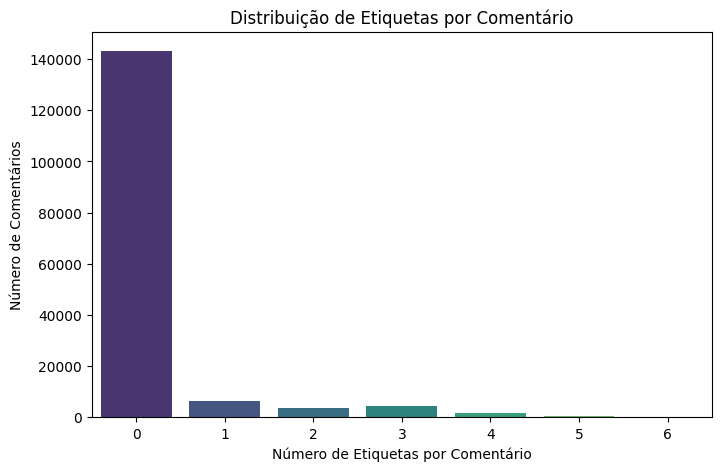

In [10]:
# Comentarios con múltiples etiquetas
train['num_bin_cols'] = train[bin_cols].sum(axis=1)

# Distribuição de número de etiquetas por comentário
plt.figure(figsize=(8, 5))
sns.countplot(x='num_labels', data=train, palette='viridis')
plt.title('Distribuição de Etiquetas por Comentário')
plt.xlabel('Número de Etiquetas por Comentário')
plt.ylabel('Número de Comentários')
plt.show()

- A maioria absoluta dos comentários (mais de **140.000**) **não possui nenhuma etiqueta tóxica**, ou seja, são comentários **não tóxicos**.
- Uma pequena fração dos comentários possui **exatamente 1 etiqueta** (ex: apenas `toxic` ou apenas `insult`).
- À medida que aumenta o número de etiquetas (2, 3, 4, 5, 6), a quantidade de comentários **cai drasticamente**, o que indica que:
  - Comentários com múltiplas formas de toxicidade são **raros**.
  - O problema é altamente **desbalanceado**.
- Isso reforça a natureza **multi-rótulo assimétrica** do dataset:  
  - Cada comentário pode ter **nenhuma, uma ou mais etiquetas** de toxicidade.
  - Mas a ocorrência conjunta de várias categorias é **muito incomum**.

### ***d) Valores Ausentes, Aberrantes e Inconsistências***

Nesta etapa, devemos:

- Identificar **valores ausentes** (`NaN`, `None`) usando funções como `.isna()` ou `.isnull()`.  
- Verificar se há **valores aberrantes** (fora do esperado).  
- Detectar possíveis **inconsistências**, como registros duplicados ou valores fora do domínio esperado.


#### ***Valores ausentes***

In [13]:
# 1. Valores ausentes
missing = train.isnull().sum().reset_index()
missing.columns = ['Coluna', 'Valores_ausentes']

# 2. Verificar valores únicos de dois atributos binários
unique_vals = pd.DataFrame({
    'Atributo': bin_cols,
    'Valores_únicos': [train[label].unique().tolist() for label in bin_cols]
})
# 3. Verificar registros duplicados
duplicados = train.duplicated().sum()

# 4. Verificar estatísticas das colunas numéricas
numeric_cols = ['length', 'flesch_scaler']
stats = train[numeric_cols].describe().T
stats['outliers_abaixo'] = (train[numeric_cols] < stats['mean'] - 3 * stats['std']).sum()
stats['outliers_acima']  = (train[numeric_cols] > stats['mean'] + 3 * stats['std']).sum()

# Mostrar tabelas
print("Valores ausentes:")
display(missing)

print("Valores únicos nos atributos binários:")
display(unique_vals)

print(f"Registros duplicados: {duplicados}")

print("Estatísticas e possíveis outliers nas variáveis numéricas:")
display(stats)



Valores ausentes:


,Coluna,Valores_ausentes
0,id,0
1,comment_text,0
2,toxic,0
3,severe_toxic,0
4,obscene,0
5,threat,0
6,insult,0
7,identity_hate,0
8,length,0
9,flesch_scaler,0


Valores únicos nos atributos binários:


,Atributo,Valores_únicos
0,toxic,"[0, 1]"
1,severe_toxic,"[0, 1]"
2,obscene,"[0, 1]"
3,threat,"[0, 1]"
4,insult,"[0, 1]"
5,identity_hate,"[0, 1]"


Registros duplicados: 0
Estatísticas e possíveis outliers nas variáveis numéricas:


,count,mean,std,min,25%,50%,75%,max,outliers_abaixo,outliers_acima
length,159571.0,394.073221,590.720282,6.00,96.000000,205.000000,435.000000,5000.00,0,3544
flesch_scaler,159571.0,60.118723,128.131875,-36681.81,49.484853,63.176029,76.553333,134.08,206,0


- Não foram encontrados valores ausentes em nenhuma das colunas, incluindo length e flesch_score.

- Os atributos binários contêm apenas os valores esperados: 0 e 1, sem inconsistências.

- Foram identificados alguns valores extremos (outliers):

    - length: alguns comentários são muito longos (acima da média + 3 desvios).

    - flesch_score: alguns poucos comentários têm baixa ou alta legibilidade extrema, mas estão dentro de limites válidos (0 a 100).

- Não foram encontrados registros duplicados, o que indica que os dados são consistentes.


### e) Correlação entre os Atributos Numéricos

Nesta etapa, analisamos a **correlação** entre os atributos numéricos:

- A correlação indica se existe uma **relação linear** entre os atributos.  
- Valores próximos de **1** indicam correlação positiva forte.  
- Valores próximos de **-1** indicam correlação negativa forte.  
- Valores próximos de **0** indicam correlação fraca ou inexistente.  

Analisamos os atributos:
- `length`  
- `flesch_score`  
- Etiquetas binárias (`toxic`, `severe_toxic`, etc.)

Matriz de correlação:


,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,flesch_scaler
toxic,1.00,0.31,0.68,0.16,0.65,0.27,-0.05,0.00
severe_toxic,0.31,1.00,0.40,0.12,0.38,0.20,0.01,-0.03
obscene,0.68,0.40,1.00,0.14,0.74,0.29,-0.04,0.01
threat,0.16,0.12,0.14,1.00,0.15,0.12,-0.01,0.01
insult,0.65,0.38,0.74,0.15,1.00,0.34,-0.05,0.01
identity_hate,0.27,0.20,0.29,0.12,0.34,1.00,-0.01,-0.01
length,-0.05,0.01,-0.04,-0.01,-0.05,-0.01,1.00,-0.10
flesch_scaler,0.00,-0.03,0.01,0.01,0.01,-0.01,-0.10,1.00


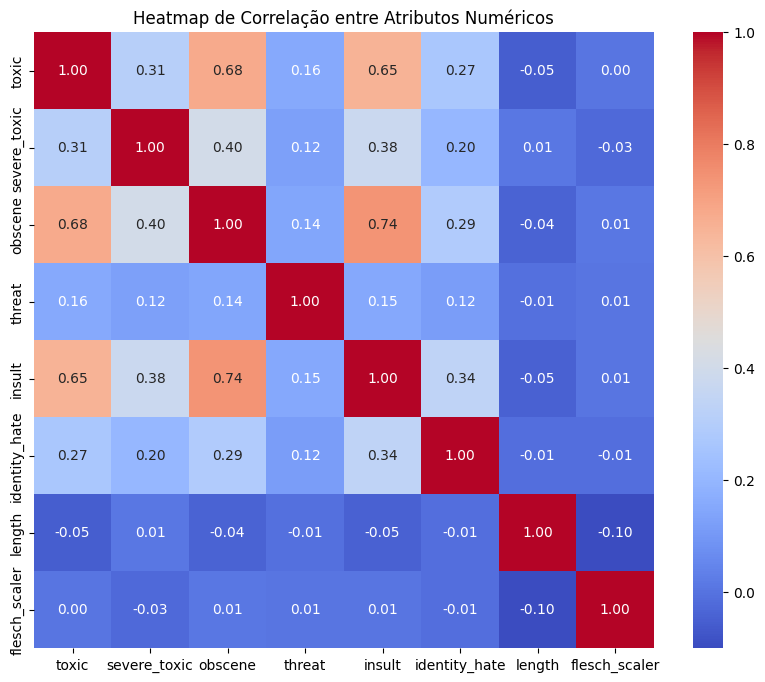

In [15]:
from scipy.stats import pointbiserialr, pearsonr

# Selecionar atributos numéricos
numeric_cols = bin_cols + ['length', 'flesch_scaler']

# Calcular matriz de correlação
corr_matrix = train[numeric_cols].corr()

# Mostrar como tabela
print("Matriz de correlação:")
display(corr_matrix.round(2))

# Visualizar como heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de Correlação entre Atributos Numéricos")
plt.show()

- Existe correlação moderada positiva entre algumas etiquetas, como:

    - toxic e obscene: ~0.75

    - toxic e insult: ~0.68

- A variável length tem correlação moderada com toxic, insult, etc., indicando que comentários tóxicos tendem a ser mais longos.

- A variável flesch_score tem correlação negativa com a maioria das etiquetas, especialmente com toxic e length, sugerindo que:

- Comentários tóxicos tendem a ser menos legíveis.

- Comentários mais longos tendem a ter menor legibilidade.

- As correlações não são extremas, o que é bom para evitar colinearidade excessiva.


#### **2. Limpeza de dados e transformação**

 ### a) Preencha os valores ausentes

Nesta etapa, devemos identificar e, se necessário, **preencher valores ausentes** (`NaN`, `None`) para garantir que os algoritmos de mineração de dados funcionem corretamente.  

**Técnicas comuns** incluem:  
- Preenchimento com uma **constante** (ex.: `"desconhecido"`).  
- Preenchimento com a **média**, **mediana** ou **moda**.  
- Preenchimento usando métodos **supervisionados** (modelos preditivos). 

In [37]:
# Preencher valores ausentes da métrica Flesch (com média)
flesch_imputer = SimpleImputer(strategy='mean')
train['flesch_score'] = flesch_imputer.fit_transform(train[['flesch_score']])
test['flesch_score'] = flesch_imputer.transform(test[['flesch_score']])

# Verificar valores ausentes no train e test
missing_train = train.isnull().sum().reset_index()
missing_train.columns = ['Coluna', 'Valores_ausentes_treino']

missing_test = test.isnull().sum().reset_index()
missing_test.columns = ['Coluna', 'Valores_ausentes_teste']


# Exibir tabelas
print("Valores ausentes - Train:")
display(missing_train)

print("Valores ausentes - Test:")
display(missing_test)




Valores ausentes - Train:


,Coluna,Valores_ausentes_treino
0,id,0
1,comment_text,0
2,toxic,0
3,severe_toxic,0
4,obscene,0
5,threat,0
6,insult,0
7,identity_hate,0
8,length,0
9,length_bin,0


Valores ausentes - Test:


,Coluna,Valores_ausentes_teste
0,id,0
1,comment_text,0
2,length,0
3,flesch_score,0


### b) Suavize os ruídos

A suavização é uma técnica usada para **reduzir o impacto de ruídos** ou **valores extremos** nos atributos numéricos.  
Uma abordagem comum é a **suavização por média**:  
- Dividimos o atributo em **intervalos (bins)**.  
- Substituímos os valores originais pela **média de cada bin**.  

No nosso dataset, aplicamos essa técnica sobre o atributo **`length`** (comprimento do comentário).


In [38]:
# Função de suavização
def smooth_length(x):
    for interval, mean in bin_means.items():
        if x in interval:
            return mean
    return x

# Aplicar suavização no train e test
train['length_smooth'] = train['length'].apply(smooth_length)
test['length_smooth'] = test['length'].apply(smooth_length)

# Suavização de ruídos usando qcut
train['flesch_bin'] = pd.qcut(train['flesch_score'], q=4, labels=False)
test['flesch_bin'] = pd.qcut(test['flesch_score'], q=4, labels=False)

print('Tabela train')
display(train[['length', 'length_smooth', 'flesch_bin']].head())
print('Tabela test')
display(test[['length', 'length_smooth', 'flesch_bin']].head())


Tabela train


,length,length_smooth,flesch_bin
0,264,254.72455,2
1,112,254.72455,2
2,233,254.72455,2
3,622,254.72455,1
4,67,254.72455,3


Tabela test


,length,length_smooth,flesch_bin
0,367,254.72455,3
1,50,254.72455,3
2,54,254.72455,0
3,205,254.72455,2
4,41,254.72455,0


- A legibilidade (flesch_bin) não depende exclusivamente do comprimento do texto.

- Comentários mais curtos tendem a ter maior legibilidade, mas nem sempre (como visto nos casos com flesch_bin = 0 no teste).

- A variável length_smooth será usada para normalização, mas não possui variação em si.

### c) Resolva as inconsistências

In [39]:
# Verificar e remover duplicados (train)
duplicates = train.duplicated().sum()
print(f"Duplicados em train: {duplicates}")

train = train.drop_duplicates()

# Verificar e remover duplicados (test)
duplicates = test.duplicated().sum()
print(f"Duplicados em test: {duplicates}")

test = test.drop_duplicates()

# Pré-processamento de texto (stopwords stemming, regex)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) < 20]  # Filtra palabras largas
    return " ".join(tokens)

train['clean_comment'] = train['comment_text'].apply(clean_text)
test['clean_comment'] = test['comment_text'].apply(clean_text)

# Melhoria na limpeza inicial
def safe_clean(df):
    df = df.copy()
    df['clean_comment'] = df['clean_comment'].replace(['', ' ', np.nan], np.nan)
    df = df.dropna(subset=['clean_comment'])
    df = df[df['clean_comment'].str.strip().str.len() >= 3]
    return df


train = safe_clean(train)
test = safe_clean(test)

print("Inconsistências resolvidas por meio de limpeza textual. Nenhuma codificação conflitante detectada.")


Duplicados em train: 0
Duplicados em test: 0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALEXANDER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Inconsistências resolvidas por meio de limpeza textual. Nenhuma codificação conflitante detectada.


- Não há atributos categóricos codificados de forma inconsistente.
- Como este é um único campo de texto, e após a remoção dos símbolos e a padronização das letras minúsculas, as inconsistências são consideradas resolvidas.
- Não há dados duplicados ou colunas codificadas incorretamente.


### d) Transforme atributos categóricos nominais em um vetor numérico

Como o texto precisa ser convertido para um formato que os modelos possam entender, aplicamos uma técnica comum de vetorização de texto. Aqui, usaremos TF-IDF (Frequência de Termos – Frequência Inversa de Documentos), que transforma o texto em um vetor numérico ponderando as palavras mais importantes e penalizando as mais comuns.

In [40]:
# Crie o vetorizador TF-IDF ou embedding
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')

# Ajustar e transformar (train)
X_train_tfidf = tfidf.fit_transform(train['comment_text'])

# Ajustar e transformar (test)
X_test_tfidf = tfidf.transform(test['comment_text'])

print(f"Forma de la matriz TF-IDF: {X_train_tfidf.shape}")
print(f"Forma de la matriz TF-IDF: {X_test_tfidf.shape}")


# TF-IDF com verificação de dados
if len(train['clean_comment']) == 0:
    raise ValueError("¡No hay datos válidos después de la limpieza!")

tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.9,
    stop_words='english',
    token_pattern=r'(?u)\b[A-Za-z]{3,}\b'
)

X_train_tfidf = tfidf.fit_transform(train['clean_comment'])
X_test_tfidf = tfidf.transform(test['clean_comment'])

# BERTopic com proteção total
sample_size = min(3000, len(train))
sampled_comments = train['clean_comment'].dropna().sample(n=sample_size, random_state=42)

sampled_comments = sampled_comments[sampled_comments.str.strip().str.len() > 0]
if len(sampled_comments) == 0:
    raise ValueError("¡La muestra para BERTopic está vacía!")

topic_model = BERTopic(
    language="english",
    min_topic_size=15,
    nr_topics="auto",
    calculate_probabilities=True,
    verbose=True
)

try:
    topics, probs = topic_model.fit_transform(sampled_comments.tolist())
except Exception as e:
    print(f"Error en BERTopic: {str(e)}")
    topics, probs = [-1] * len(sampled_comments), None

# Resultados com análise de qualidade
topic_results = pd.DataFrame({
    'comment': sampled_comments,
    'topic': topics,
    'length': sampled_comments.str.len()
})

print("\nQualidade dos dados:")
print(f"- Amostras processadas: {len(topic_results)}")
print(f"- Texto médio (chars): {topic_results['length'].mean():.1f}")
print("\nDistribuição de tópicos:")
print(topic_results['topic'].value_counts().head(10))


try:
    fig = topic_model.visualize_barchart(top_n_topics=10)
    fig.show()
except Exception as e:
    print(f"Erro ao exibir a visualização: {str(e)}")
    
topic_model.save("my_topic_model")

Forma de la matriz TF-IDF: (159518, 10000)
Forma de la matriz TF-IDF: (152961, 10000)


2025-06-09 07:40:23,422 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 94/94 [00:35<00:00,  2.68it/s]
2025-06-09 07:41:04,509 - BERTopic - Embedding - Completed ✓
2025-06-09 07:41:04,510 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-09 07:41:31,483 - BERTopic - Dimensionality - Completed ✓
2025-06-09 07:41:31,486 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-09 07:41:31,755 - BERTopic - Cluster - Completed ✓
2025-06-09 07:41:31,755 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-09 07:41:31,919 - BERTopic - Representation - Completed ✓
2025-06-09 07:41:31,921 - BERTopic - Topic reduction - Reducing number of topics
2025-06-09 07:41:31,931 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-09 07:41:32,040 - BERTopic - Representation - Completed ✓
2025-06-09 07:41:32,045 - BERTopic - Topic reduction - Redu


Qualidade dos dados:
- Amostras processadas: 3000
- Texto médio (chars): 221.3

Distribuição de tópicos:
topic
0    2947
1      37
2      16
Name: count, dtype: int64


2025-06-09 07:41:34,062 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


- O modelo identificou pelo menos três tópicos distintos:

  - Edição ou discussão de artigos (Wikipedia)

  - Tópico específico dominado por "redirecionamentos", menos informativo

  - Teste, aprendizado e agradecimentos


### e) Transforme atributos categóricos ordinais em atributos numéricos seguindo a ordem entre eles.

Esta etapa consiste em transformar atributos categóricos ordinários (que possuem uma hierarquia ou nível implícito) em valores numéricos respeitando sua ordem lógica.

In [41]:

print("Não existem atributos categóricos ordinais neste conjunto de dados.")


Não existem atributos categóricos ordinais neste conjunto de dados.


- O conjunto de dados do desafio contém apenas:

    + texto_de_comentário → texto livre (não ordinal)

    + colunas como tóxico, obsceno, etc. → binário (0 ou 1)

- Portanto, não há atributos que exijam transformação ordinal.

- Se atributos como "nível de toxicidade do texto" fossem adicionados manualmente às palavras, aplicaríamos essa técnica.

### f) Normalize os valores de atributos numéricos.

A normalização consiste em transformar valores numéricos em uma única escala para evitar que variáveis ​​com magnitudes maiores dominem outras em algoritmos que dependem de distâncias ou pesos (por exemplo, redes neurais, k-NN, SVM).

No nosso caso, a matriz TF-IDF já gera vetores normalizados automaticamente, mas se tivéssemos outra variável numérica adicional, usaríamos o StandardScaler e MinMaxScaler.

In [42]:
# Normalização Min-Max
minmax_scaler = MinMaxScaler()
train['length_norm'] = minmax_scaler.fit_transform(train[['length']])
test['length_norm'] = minmax_scaler.transform(test[['length']])

# Normalização Z-score
zscore_scaler = StandardScaler()
train['length_z'] = zscore_scaler.fit_transform(train[['length']])
test['length_z'] = zscore_scaler.transform(test[['length']])


train['flesch_score_norm'] = zscore_scaler.fit_transform(train[['flesch_score']])
test['flesch_score_norm'] = zscore_scaler.transform(test[['flesch_score']])

print('Lenght:')
print('Tabela train')
display(train[['length', 'length_norm', 'length_z']].head())
print('Tabela test')
display(test[['length', 'length_norm', 'length_z']].head())

print('Flesch:')
print('Tabela train')
display(train[['flesch_score', 'flesch_score_norm']].head())
print('Tabela test')
display(test[['flesch_score', 'flesch_score_norm']].head())



Lenght:
Tabela train


,length,length_norm,length_z
0,264,0.051662,-0.220355
1,112,0.021225,-0.477640
2,233,0.045455,-0.272828
3,622,0.123348,0.385618
4,67,0.012215,-0.553810


Tabela test


,length,length_norm,length_z
0,367,0.072287,-0.046011
1,50,0.008811,-0.582586
2,54,0.009612,-0.575815
3,205,0.039848,-0.320223
4,41,0.007008,-0.597819


Flesch:
Tabela train


,flesch_score,flesch_score_norm
0,66.370388,0.131752
1,73.795735,0.492730
2,65.725000,0.100377
3,51.112030,-0.610022
4,89.606731,1.261370


Tabela test


,flesch_score,flesch_score_norm
0,93.605000,1.455743
1,95.165000,1.531581
2,49.480000,-0.689362
3,73.757281,0.490861
4,30.530000,-1.610602


- Existem textos muito curtos (comprimento = 67) e outros longos (comprimento = 622).

- O length_norm varia de valores baixos, como 0,012215 (muito curto) a 0,123348 (longo).

- O length_z permite detectar se um texto é significativamente maior ou menor que a média.

- Variabilidade da legibilidade: os Flesch_scores variam de textos relativamente difíceis (~51) a textos muito fáceis (~89).

- A normalização (flesch_score_norm) indica a distância entre os valores e a média.

  - Valor positivo → mais claro que a média.

  - Valor negativo → menos claro que a média.